# Significance testing on Compound Sentiment scores of Amazon reviews

We are going to perform a series of statistical tests, whether they may be parametric or non-parametric tests on the compounding scores, computed from review bodies, using the Vader library.

**Objective: Is the population mean of the compound sentiment for Amazon product reviews different between varying product categories?**

*Note: We have 12 unique categories inside our collective Amazon reviews dataset*

In [12]:
from read_data import get_output_amazon_data
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import itertools

# Load the Amazon reviews dataset

In [16]:
amazon_reviews = get_output_amazon_data()
unique_categories = amazon_reviews["product_category"].unique()
amazon_reviews.shape

(1129386, 8)

# Checking normality of review body compounding sentiment scores

We are going to make a histogram, to illustrate over 1 million reviews from varying product categories

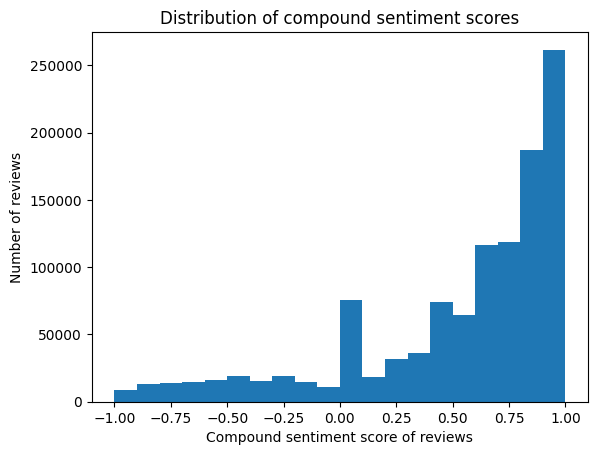

In [15]:
plt.hist(x=amazon_reviews["review_body_compound_score"], bins=20)
plt.xlabel("Compound sentiment score of reviews")
plt.ylabel("Number of reviews")
plt.title("Distribution of compound sentiment scores")
plt.show()

# Distribution interpretation
Clearly, the compound sentiment scores of the reviews aren't normally distributed from this histogram plot above. It seems a large majority of reviews are skewed towards positivity in terms of their text content. 

A reminder that if the compound score >= 0.05, then it is considered **positive**.

# Normality test from scipy.stats module
Let's do a normality test to confirm our visual interpretation, that the compound scores aren't normal.

We can also do normality tests on each individual product category's reviews.

In [22]:
entire_data_normality_result = stats.normaltest(amazon_reviews["review_body_compound_score"])
print(f"The p-value of the compound scores on the entire dataset is: {entire_data_normality_result.pvalue}")

passes_normality: List[str] = []
p_values: List[float] = []

for product_category in unique_categories:
    product_review_compound_scores = amazon_reviews[amazon_reviews["product_category"] == product_category]["review_body_compound_score"]
    test_result = stats.normaltest(product_review_compound_scores)

    p_values.append(test_result.pvalue)
    passes_normality.append("Yes" if test_result.pvalue >= 0.05 else "No")

normality_by_product = pd.DataFrame({
    "product_category": unique_categories,
    "p-value": p_values,
    "Is Normal?": passes_normality
})
normality_by_product

The p-value of the compound scores on the entire dataset is: 0.0


,product_category,p-value,Is Normal?
0,Automotive,0.0,No
1,Tools,0.0,No
2,Apparel,0.0,No
3,Shoes,0.0,No
4,Software,0.0,No
5,Watches,0.0,No
6,Video Games,0.0,No
7,Sports,0.0,No
8,Electronics,0.0,No
9,Grocery,0.0,No


# Which test should we use to answer our objective in this analysis? 
The normality test has clearly failed for the compound scores of each product category, and statistical tests such as t-testing require/assume that normality and equal variance conditions are satisfied. 

The best choice is to perform a non-parametric test, called **Mann-whitney U-test**.


# U-test (Mann-Whitney) on all the pairs of compound sentiment scores on the 12 product categories

Since we know that customer reviews on Amazon products inside our collective data frame aren't normal, it is a good idea to try a commonly used non-parametric significance test called the **Mann-Whitney U-test**.

In the cell below, we can generate all the possible pairs of product categories using the combinations functions inside the itertools library that is built into Python. The r-value of the combinations is 2, as each mean comparison has 2 groups obviously. 

In order to aggregate these p-values into a data structure, there is a data frame that holds **Product Category A**, **Product Category B**, **p-value from the U-test**, and **means different**, if the p-value is less than the significance level of 0.05. 

In [23]:
category_combinations = list(itertools.combinations(unique_categories, 2))
product_dfs: Dict[str, pd.DataFrame] = {unique_category : amazon_reviews[amazon_reviews["product_category"] == unique_category] 
                                        for unique_category in unique_categories}

category_a: List[str] = []
category_b: List[str] = []
p_values: List[float] = []
means_different: List[str] = []

for item_a, item_b in category_combinations:
    compound_scores_a = product_dfs[item_a]["review_body_compound_score"].sort_values()
    compound_scores_b = product_dfs[item_b]["review_body_compound_score"].sort_values()

    u_test_result = stats.mannwhitneyu(compound_scores_a, compound_scores_b)
    p_value = u_test_result.pvalue

    category_a.append(item_a)
    category_b.append(item_b)
    p_values.append(p_value)
    means_different.append("Yes" if p_value < 0.05 else "No")

u_tests_table = pd.DataFrame({
    "Product Category A": category_a,
    "Product Category B": category_b,
    "p-value": p_values,
    "Means different?": means_different
})

u_tests_table

,Product Category A,Product Category B,p-value,Means different?
0,Automotive,Tools,2.625003e-03,Yes
1,Automotive,Apparel,0.000000e+00,Yes
2,Automotive,Shoes,0.000000e+00,Yes
3,Automotive,Software,5.118950e-66,Yes
4,Automotive,Watches,0.000000e+00,Yes
...,...,...,...,...
61,Electronics,Personal_Care_Appliances,5.681799e-40,Yes
62,Electronics,Furniture,8.808216e-205,Yes
63,Grocery,Personal_Care_Appliances,0.000000e+00,Yes
64,Grocery,Furniture,1.259608e-05,Yes


In [24]:
u_tests_table.groupby(by="Means different?").agg({"Means different?": "count"})

,Means different?
Means different?,
Yes,66


# Conclusion
It seems that based on the results of the non-parametric Mann-Whitney test, the mean compound sentiment scores of different product categories on Amazon are different. This suggests that buyers may rate things to a different level of positivity, depending on the type of product they are buying. 

We are only discussing review body positivity because it seems that a large majority of reviews in the dataset are skewed toward positive compounds 